# Contextual Bandits Agent with Policy Gradient Method (Deterministic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [177]:
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
import pandas as pd

In [178]:
from scipy.special import logit, expit
from PolicyGradientAgent import DeterministicGradientAgent
from Environment import *

In [397]:
learning_rate_theta = 1e-4
decay_rate = 0 #0.001
learning_rate_wv = 1e-4
learning_rate_wq = 1e-2
memory_size = 16
batch_size = 16
training_episodes = 900000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
# Bucket parameters
prior_red_list = [3/4, 1/4]
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3

agent = DeterministicGradientAgent(
    feature_shape=[1, 3], 
    learning_rate_theta=learning_rate_theta,
    learning_rate_wv = learning_rate_wv,
    learning_rate_wq=learning_rate_wq, 
    memory_size= memory_size, 
    batch_size=batch_size,
    beta1=beta1, 
    beta2=beta2
)

explorer = Explorer(feature_shape=[1, 3], learning= False, init_learning_rate=3e-4, min_std=0.1)


reward_history_list = []


mean_weights_history_list = []
q_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []


r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []


grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []


grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []

explorer_std_list = []

grad_mean_history_list = []
grad_v_history_list = []
grad_q_history_list = []
mean_history_list = []
actor_report_history_list = []


for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
    # Prepare a bucket and a prediction market
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(logit(prior_red))

    mean = agent.report(x)
    pi = expit(mean)
    actor_report = [pi, 1-pi]
    explorer.set_parameters(mean=mean, std=0.3)
    explorer_report = explorer.report(x)
#     _pi = np.random.uniform() # uniform doesn't work, reason unknown.
#     explorer_report = [_pi, 1-_pi]
    
    explorer_std_list.append(explorer.std)

    pm.report(explorer_report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
#     pm.report(actor_report)
#     actual_R = pm.log_resolve(bucket_colour_to_num[bucket.colour])

    
    mean_weights_history_list.append(agent.theta_mean[0].tolist())
    q_weights_history_list.append(agent.w_q[0].tolist())

    actual_pr_ru_S = 0
    expected_log_reward = 0
    max_expected_log_reward = 0
    regret = 0
    if signal == 'red':
        actual_pr_ru_S = analytical_best_report_ru_rs(pr_ru=prior_red, pr_rs_ru=pr_red_ball_red_bucket, pr_rs_bu=pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=actual_pr_ru_S, pr_ru=prior_red)
    else:
        actual_pr_ru_S = analytical_best_report_ru_bs(pr_ru=prior_red, pr_bs_ru=1-pr_red_ball_red_bucket, pr_bs_bu=1-pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=actual_pr_ru_S, pr_ru=prior_red)
    

    action = logit(explorer_report[0])
    [v], [q] = agent.store_experience(x, action, R, t)

    explorer.update(R, x)

    try:
        grad_mean, \
        gradient_v, \
        gradient_q, \
        v_dw_mean_corrected, \
        s_dw_mean_corrected = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)
    
    
    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)
#     if explorer.learning:
#         explorer.learning_rate_decay(epoch=t, decay_rate=0.001)
        
    
    reward_history_list.append([R, max_expected_log_reward - expected_log_reward, v, q, signal, prior_red])
        
    if signal == 'red':
        r_ball_pred_history_list.append(explorer_report[0])
        r_ball_mean_history_list.append(mean)      
    else:
        b_ball_pred_history_list.append(explorer_report[0])
        b_ball_mean_history_list.append(mean)
        
    actor_report_history_list.append([actor_report[0], signal])
    mean_history_list.append([mean, signal])
    grad_mean_history_list.append(grad_mean[0, :])    
    grad_v_history_list.append(gradient_v[0, :])
    grad_q_history_list.append(gradient_q[0, :])
        
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    #########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])        

  0%|          | 0/900000 [00:00<?, ?it/s]

learning_rate_theta= 0.0001  learning_rate_wq= 0.01
memory_size= 16
Updating weights with regular algorithm.


In [398]:
reward_history_df = pd.DataFrame(
    reward_history_list, 
    columns=[
        'explorer_reward',
        'regret',
        'v',
        'q',
        'signal',
        'prior_red'
    ]
)


mean_weights_history_df = pd.DataFrame(mean_weights_history_list, columns=['red_weight', 'blue_weight', 'prior_weight'])
q_weights_history_df = pd.DataFrame(q_weights_history_list, columns=['red_weight', 'blue_weight', 'prior_weight'])

grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)


grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)


grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)

grad_mean_history_df = pd.DataFrame(grad_mean_history_list, columns=['red_ball', 'blue_ball', 'prior'])
actor_report_history_df = pd.DataFrame(actor_report_history_list, columns=['report', 'signal'])
mean_history_df = pd.DataFrame(mean_history_list, columns=['mean', 'signal'])
grad_v_history_df = pd.DataFrame(grad_v_history_list, columns=['red_v', 'blue_v', 'prior_v'])
grad_q_history_df = pd.DataFrame(grad_q_history_list, columns=['red_q', 'blue_q', 'prior_q'])

Text(0.5, 0.98, 'Explorer Rewards and Average')

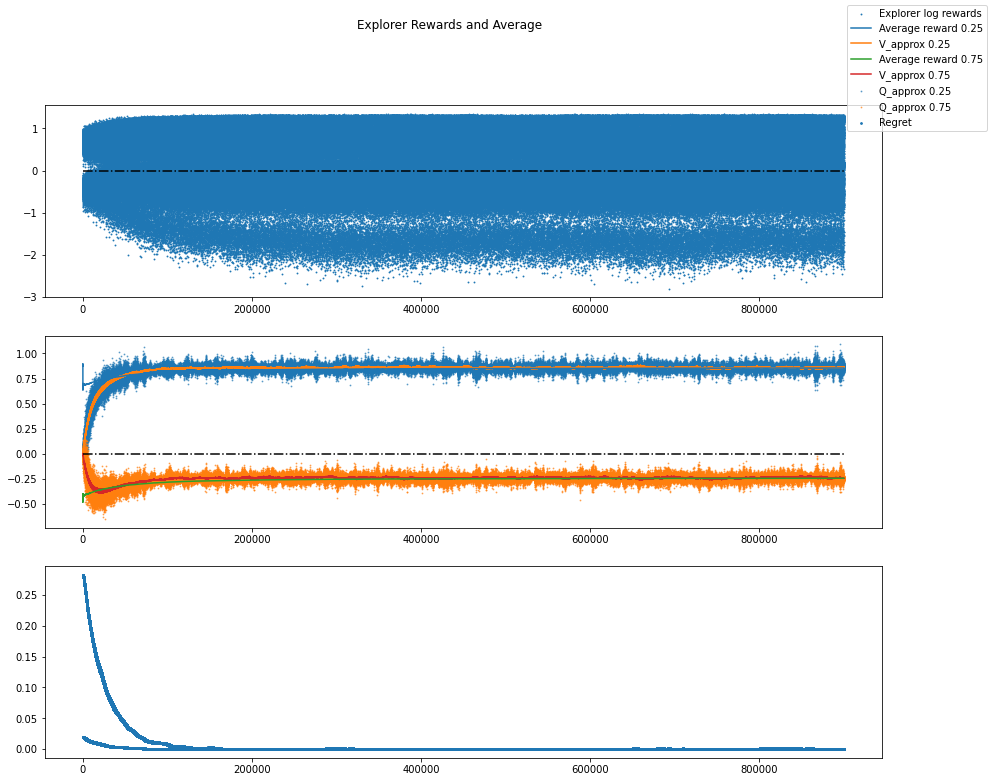

In [399]:
fig, axs = plt.subplots(3, figsize=(15, 12))
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['explorer_reward'],label = 'Explorer log rewards', marker='.', s=3, zorder=-100)
# axs[0].scatter(x=reward_history_df.index, y=reward_history_df['actual_reward'],label = 'Actor log rewards', marker='.', s=3, zorder=-99)
for prior, df in reward_history_df.reset_index().groupby('prior_red'):
    axs[1].plot(df['explorer_reward'].expanding().mean(), zorder= -97, label = 'Average reward '+str(prior) )
    axs[1].plot(df.loc[:, 'v'], zorder = -98, label = 'V_approx '+str(prior))
    axs[1].scatter(x=df['index'], y=df.loc[:, 'q'], zorder= -99, label = 'Q_approx '+str(prior), marker='.', s=3, alpha=0.6)
    
axs[2].scatter(x=reward_history_df.index, y=reward_history_df['regret'], label='Regret ', s=3)
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
fig.legend(loc='upper right')
fig.suptitle('Explorer Rewards and Average')

In [400]:
reward_history_df.iloc[0:10000, [0, 2, 3]].describe()

,explorer_reward,v,q
count,10000.000000,10000.000000,10000.000000
mean,0.157353,0.030656,0.030673
std,0.570971,0.256651,0.266312
min,-1.074470,-0.337211,-0.561154
25%,-0.377773,-0.216650,-0.214618
50%,-0.053950,-0.003515,0.002612
75%,0.722824,0.278780,0.278978
max,1.098076,0.464747,0.674824


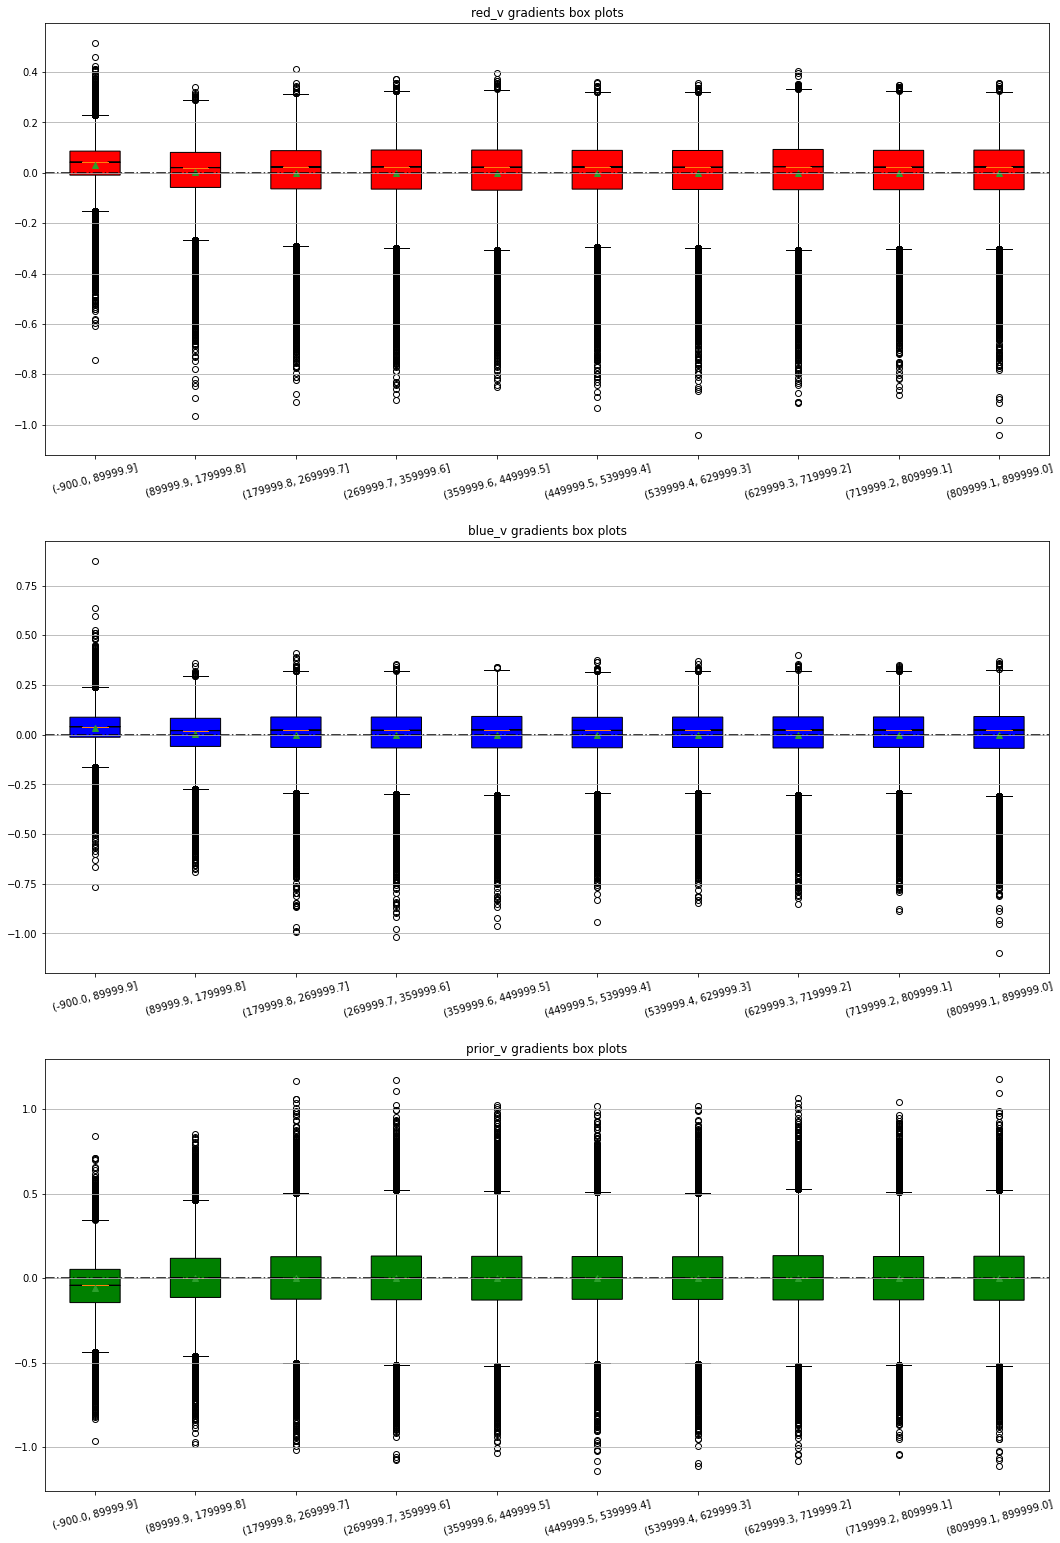

In [401]:
fig, axs = plt.subplots(3, figsize=(18, 9*3))
gradients_box_subplot(df=grad_v_history_df, column_list=grad_v_history_df.columns, colour_list=['red', 'blue', 'green'], axs=axs)

In [402]:
grad_v_history_df.iloc[-300000:, :].describe()

,red_v,blue_v,prior_v
count,300000.000000,300000.000000,300000.000000
mean,-0.000234,-0.000037,-0.000281
std,0.132786,0.132663,0.206610
min,-1.040922,-1.099227,-1.113308
25%,-0.067147,-0.066313,-0.129725
50%,0.023007,0.023445,-0.001039
75%,0.090317,0.090047,0.129316
max,0.405954,0.401050,1.179631


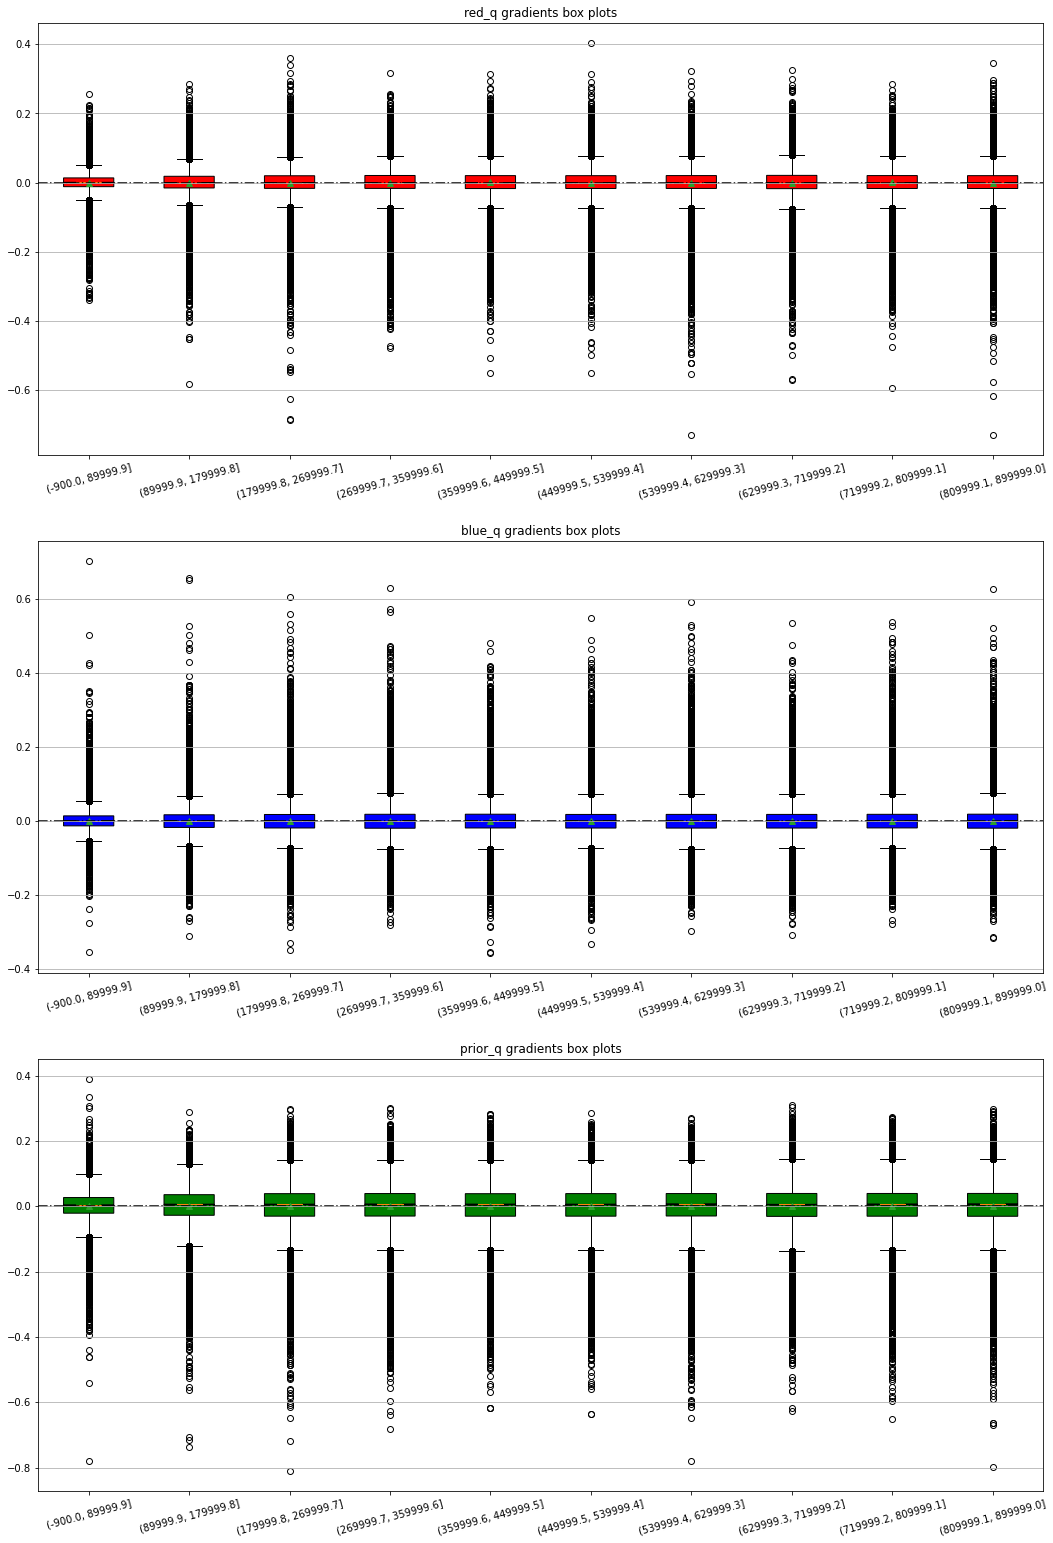

In [403]:
fig, axs = plt.subplots(3, figsize=(18, 9*3))
gradients_box_subplot(df=grad_q_history_df, column_list=grad_q_history_df.columns, colour_list=['red', 'blue', 'green'], axs=axs)
# fig.suptitle("State-Action Estimated Value Gradients")

In [404]:
grad_q_history_df.describe()

,red_q,blue_q,prior_q
count,900000.000000,900000.000000,900000.000000
mean,0.000002,0.000004,-0.000003
std,0.040207,0.040079,0.062378
min,-0.730477,-0.357696,-0.811002
25%,-0.016503,-0.018979,-0.029084
50%,-0.000145,0.000253,0.005469
75%,0.019012,0.016539,0.036931
max,0.404480,0.702271,0.390254


Text(0.5, 1.0, 'Actor Report')

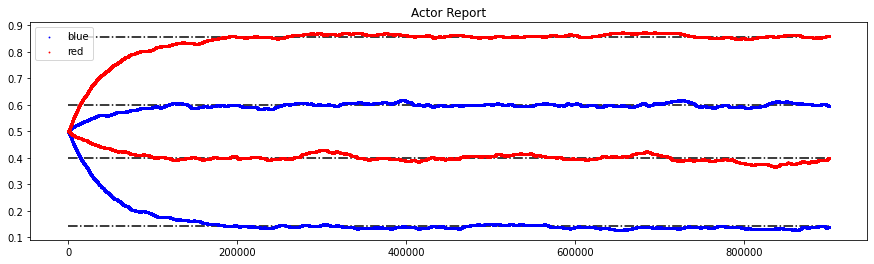

In [405]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in actor_report_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['report'], label=signal, marker='.', c=signal, s=3)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='black', linestyles='dashdot', zorder=-98)

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='black', linestyles='dashdot', zorder=-98)
ax.legend()
plt.title('Actor Report')

In [406]:
last_one_third_idx = actor_report_history_df.shape[0]//3
actor_report_history_df.iloc[-last_one_third_idx:, :].groupby('signal').describe()

report                                                              \
           count      mean       std       min       25%       50%       75%   
signal                                                                         
blue    149748.0  0.330998  0.229234  0.128489  0.135772  0.140220  0.597482   
red     150252.0  0.664420  0.230888  0.366404  0.393951  0.852287  0.860722   

                  
             max  
signal            
blue    0.617684  
red     0.873512

450164


Text(0.5, 1.0, 'Report')

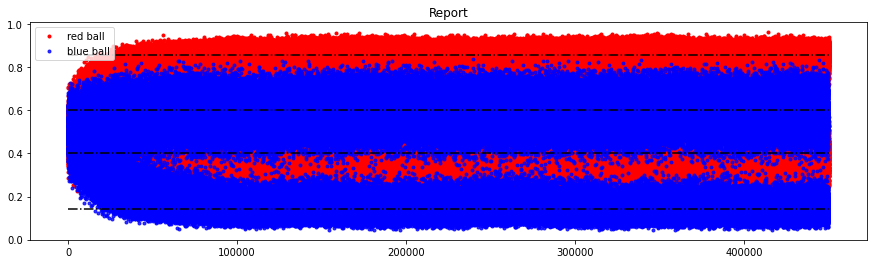

In [407]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r.', zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, 'b.', zorder=-99, label = 'blue ball', alpha=0.8)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot', zorder=-98)

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot', zorder=-98)
plt.legend()
plt.title('Report')

In [408]:
grad_mean_successive_dot = np.sum(grad_mean_history_df.iloc[:, [1]].values * np.roll(grad_mean_history_df.iloc[:, [1]].values, 1, axis=0), axis=1)[1:]
grad_mean_successive_dot

array([0.00000000e+00, 1.89276675e-05, 4.31217421e-05, ...,
       1.06421447e-03, 1.03955239e-03, 1.02067538e-03])

In [409]:
(mark_index, ) = np.where(grad_mean_successive_dot < 0)
# mark_index

In [410]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 2000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

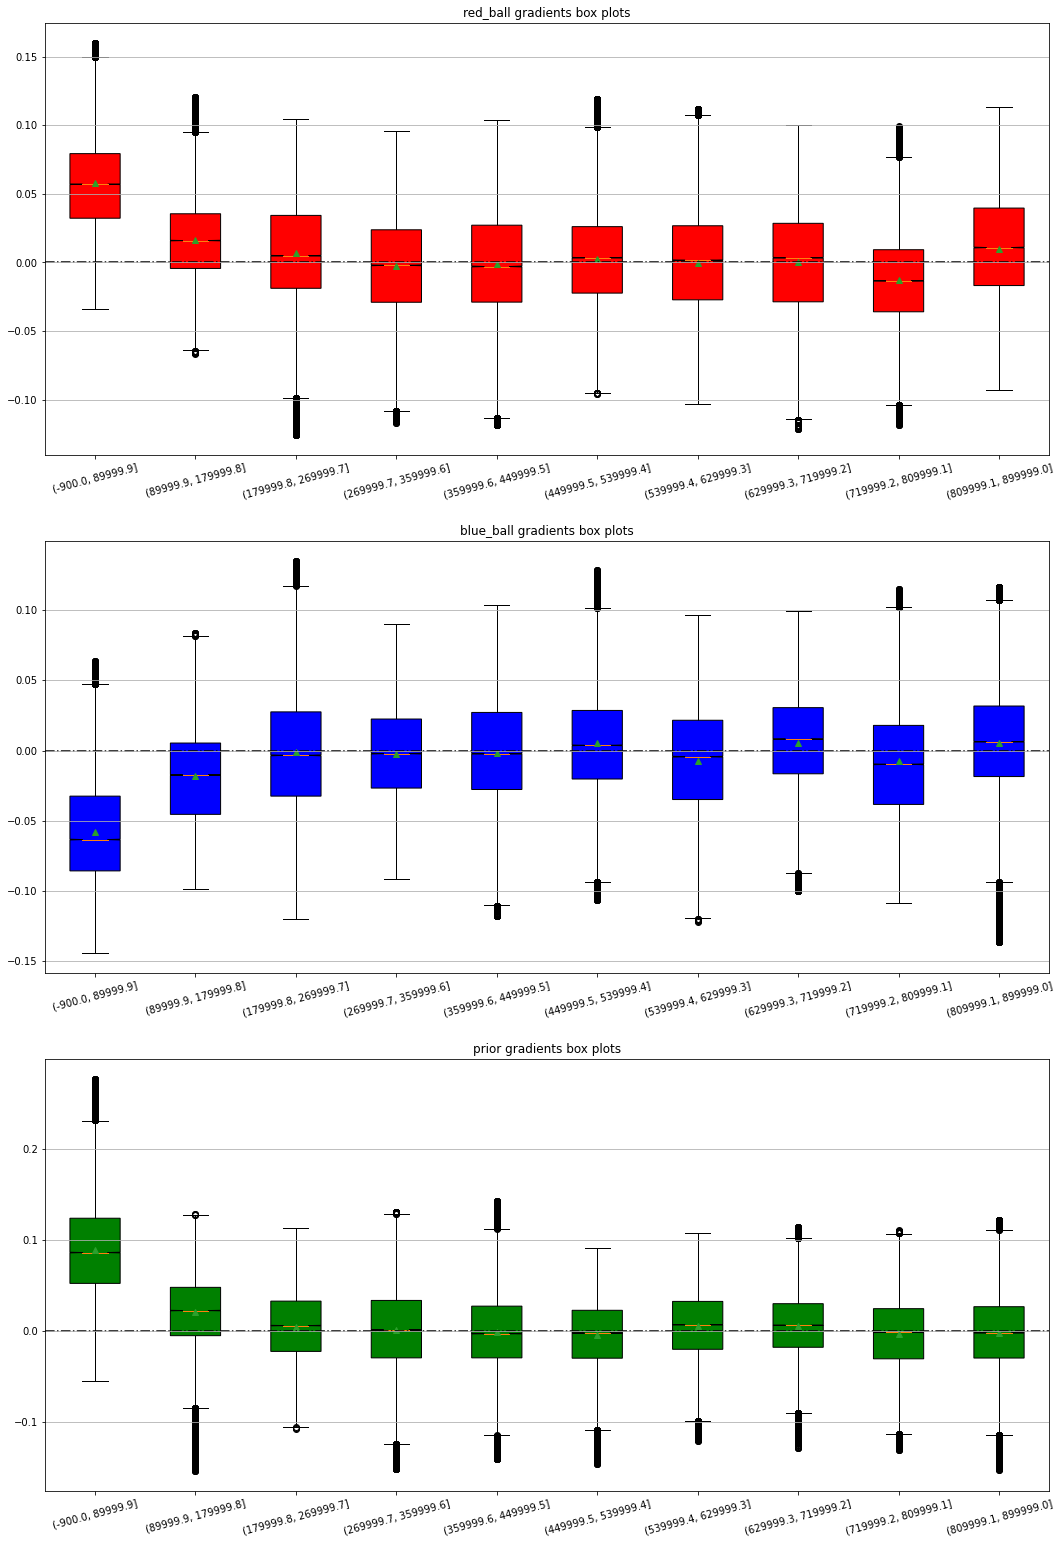

In [411]:
fig, axs = plt.subplots(3, figsize=(18, 9*3))
gradients_box_subplot(df=grad_mean_history_df, column_list=grad_mean_history_df.columns, colour_list=['red', 'blue', 'green'], axs=axs)
# fig.suptitle("Mean Gradients")

In [412]:
grad_mean_history_df.iloc[-100000:, :].describe()

,red_ball,blue_ball,prior
count,100000.000000,100000.000000,100000.000000
mean,0.007340,0.003510,-0.000882
std,0.038761,0.040736,0.043262
min,-0.093147,-0.136605,-0.152850
25%,-0.018680,-0.020676,-0.028286
50%,0.007130,0.004172,-0.000939
75%,0.036135,0.030157,0.028066
max,0.113494,0.116631,0.121511


In [413]:
from scipy.ndimage import uniform_filter1d

Text(0.5, 1.0, 'Successive gradients dot product size 1000 moving average')

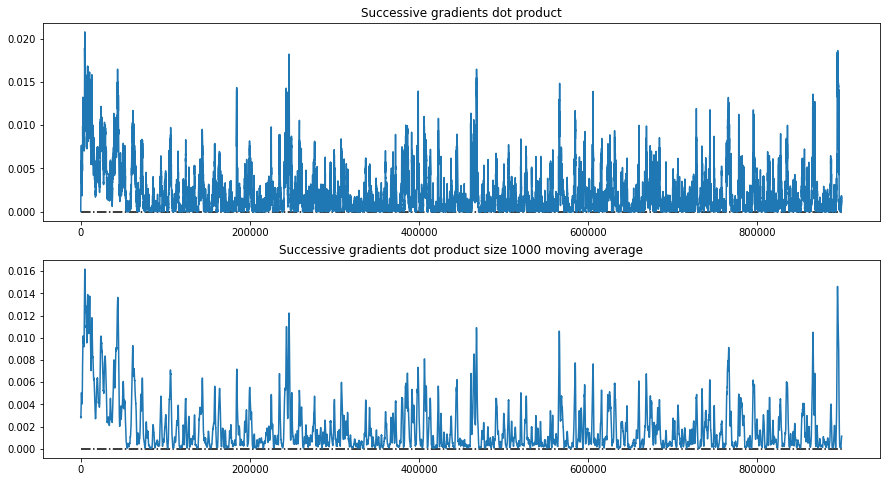

In [414]:
moving_size = 1000
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_mean_successive_dot)
axs[0].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[0].set_title('Successive gradients dot product')
axs[1].plot(uniform_filter1d(grad_mean_successive_dot, size=moving_size))
axs[1].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black')
axs[1].set_title('Successive gradients dot product size %i moving average'%moving_size)

In [415]:
if explorer.learning:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(explorer_std_list)
    plt.title('Explorer Standard Diviation')

In [416]:
import matplotlib.lines as mlines

Text(0.5, 1.0, 'Mean')

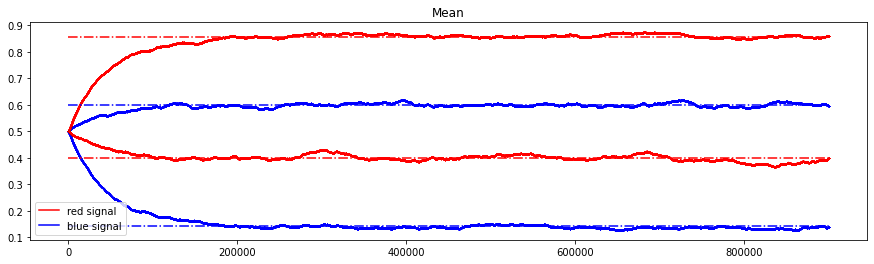

In [417]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in mean_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=expit(df['mean']), label=signal, marker='.', c=signal, alpha=0.6, s=0.1)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='red', linestyles='dashdot')

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='blue', linestyles='dashdot')
red_line = mlines.Line2D([], [], color='red', label='red signal')
blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
# for coord in phase_change_coordinates(mark_index, mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
ax.legend(handles=[red_line, blue_line], loc='lower left')
plt.title('Mean')

In [418]:
mean_history_df.iloc[-last_one_third_idx:, :].groupby('signal').describe()

mean                                                              \
           count      mean       std       min       25%       50%       75%   
signal                                                                         
blue    149748.0 -0.901440  1.113562 -1.914382 -1.850856 -1.813464  0.394983   
red     150252.0  0.874644  1.114628 -0.547674 -0.430734  1.752649  1.821303   

                  
             max  
signal            
blue    0.479729  
red     1.932372

Text(0.5, 1.0, 'Weights for Mean')

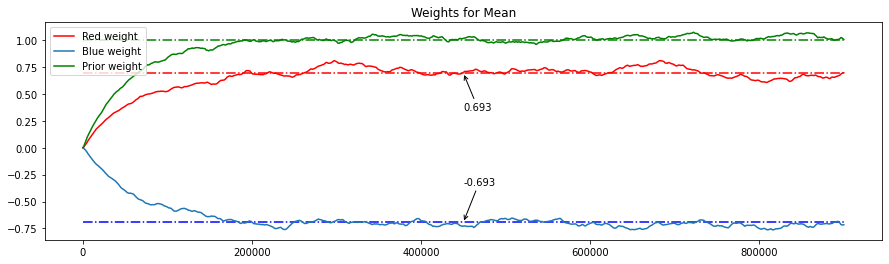

In [419]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history_df.iloc[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history_df.iloc[1:, 1], label='Blue weight')
plt.plot(mean_weights_history_df.iloc[1:, 2], 'g', label='Prior weight')
plt.hlines(y=logit(pr_red_ball_red_bucket), xmin=0, xmax=len(mean_weights_history_df), colors='red', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_red_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_red_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=logit(pr_red_ball_blue_bucket), xmin=0, xmax=len(mean_weights_history_df) , colors='blue', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_blue_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_blue_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(1/2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=1, xmin=0, xmax=len(mean_weights_history_df) , colors='green', linestyles='dashdot')
# for coord in phase_change_coordinates(mark_index, mean_weights_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
plt.legend(loc='upper left')
plt.title('Weights for Mean')

<bound method Artist.set of <Figure size 1296x1944 with 3 Axes>>

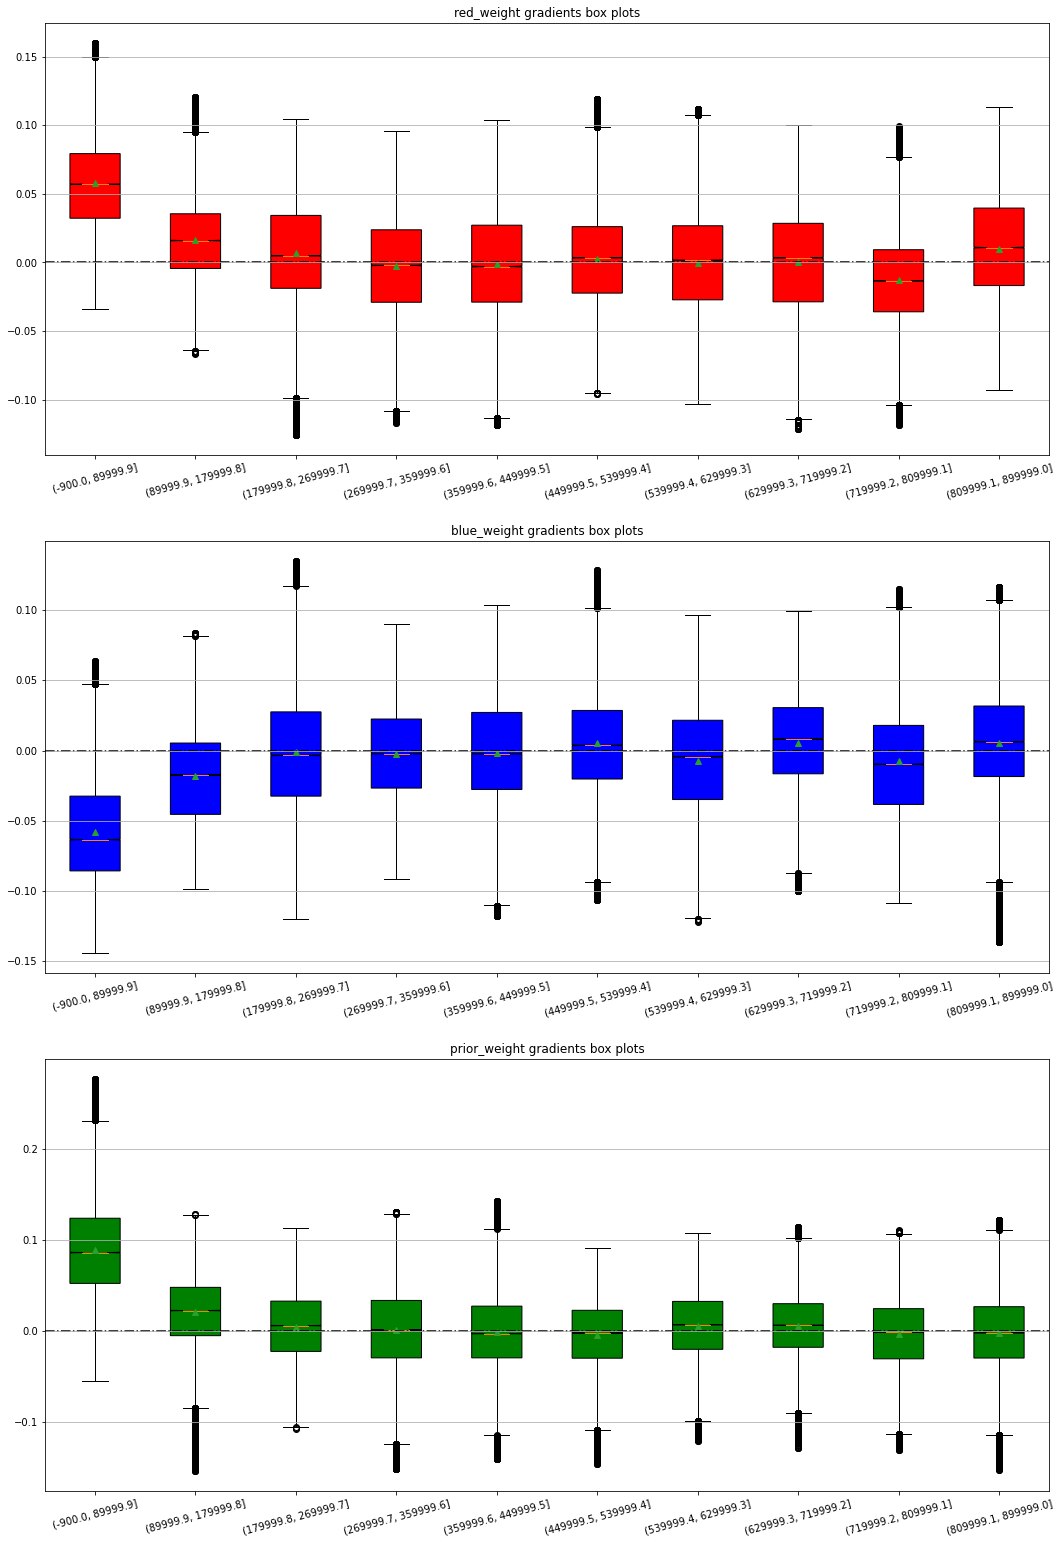

In [420]:
fig, axs = plt.subplots(3, figsize=(18, 9*3))
gradients_box_subplot(df=q_weights_history_df, column_list=q_weights_history_df.columns, colour_list=['red', 'blue', 'green'], axs=axs)
fig.set

In [421]:
query_index = mean_weights_history_df.shape[0]//3
mean_weights_history_df.iloc[-query_index:, :].describe()

,red_weight,blue_weight,prior_weight
count,300000.000000,300000.000000,300000.000000
mean,0.693102,-0.719829,1.026550
std,0.053823,0.022037,0.020960
min,0.607088,-0.763529,0.990902
25%,0.651670,-0.736728,1.009515
50%,0.674990,-0.715978,1.023363
75%,0.741799,-0.703341,1.042507
max,0.809668,-0.670655,1.072530


Text(0.5, 0.98, 'Signal Mean Gradients')

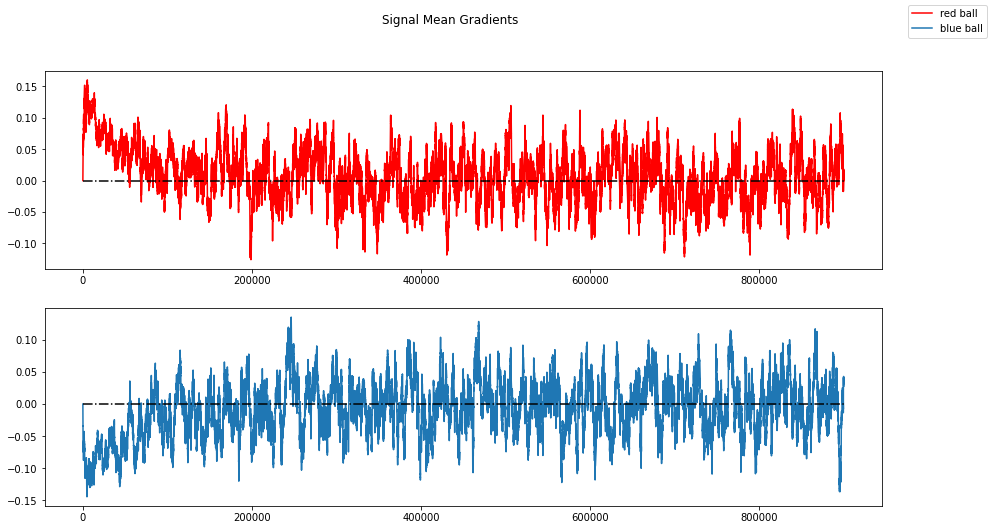

In [422]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_r_ball_mean_history)):
#     axs[0].annotate('change', xy=coord, xytext=(coord[0], coord[1] + 0.05), arrowprops=dict(arrowstyle="->"))
# for coord in phase_change_coordinates(mark_index, pd.DataFrame(grad_b_ball_mean_history)):
#     axs[1].annotate('change', xy=coord, xytext=(coord[0], coord[1] - 0.05), arrowprops=dict(arrowstyle="->"))  
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

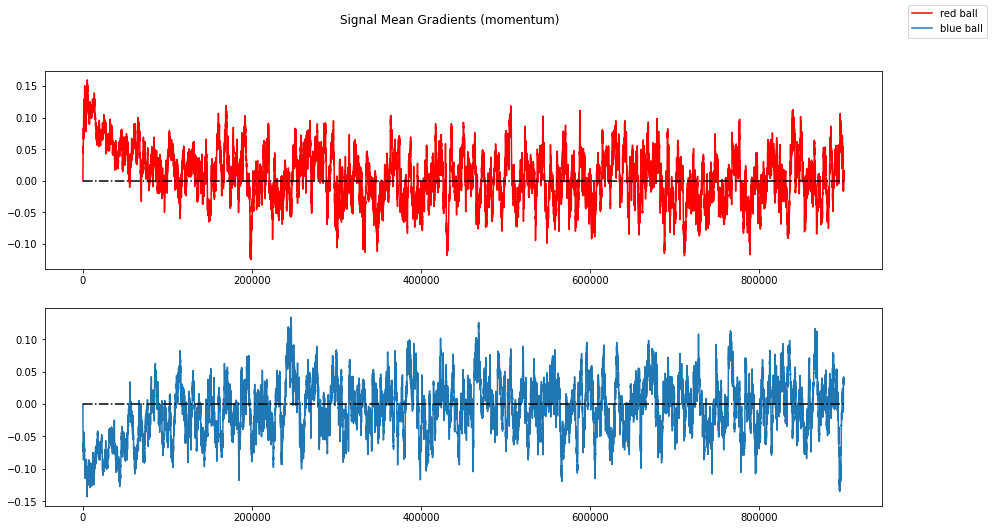

In [423]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

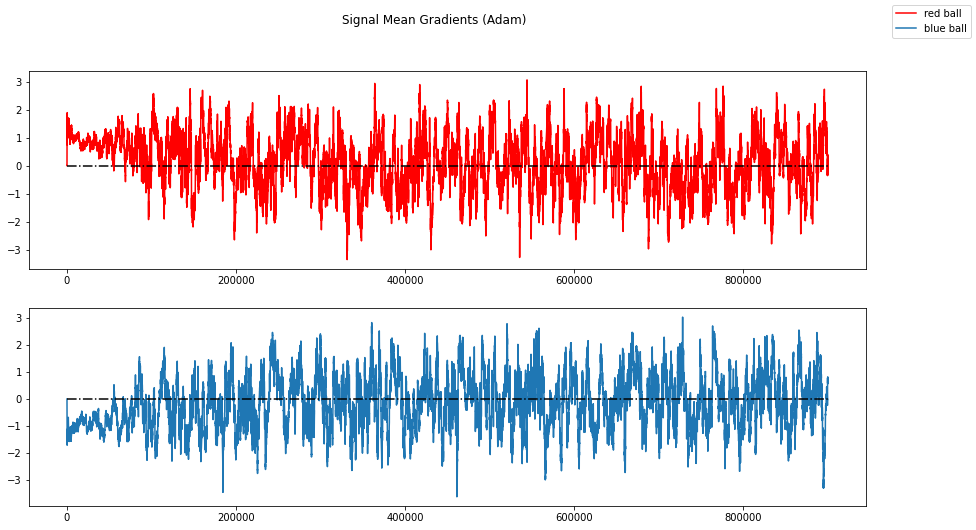

In [424]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history, 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history,label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [425]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [426]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
# axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')